In [2]:

import lvm_read
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats
import math

In [3]:
file = "trials 2.lvm"
file_calibrate = "THERM_CALIBRATE.lvm"

In [4]:
lvm = lvm_read.read(file, read_from_pickle=False)
lvm_calibrate = lvm_read.read(file_calibrate, read_from_pickle=False)

In [102]:
#Create arrays of the data

data=np.array(lvm[0]["data"])
timestamp = np.ravel(np.hsplit(data,8)[0])
V_Sample = np.ravel(np.hsplit(data,8)[3])
I_Sample = np.ravel(np.hsplit(data,8)[4])
V_Therm = np.ravel(np.hsplit(data,8)[1])
I_Therm = np.ravel(np.hsplit(data,8)[2])
V_Hall = np.ravel(np.hsplit(data,8)[5])
I_Hall = np.ravel(np.hsplit(data,8)[6])
Temp_Cryostat = np.ravel(np.hsplit(data,8)[7])

    
#Create arrays of the calibration data   
data_cal = np.array(lvm_calibrate[0]["data"])
V_Sample_Cal = np.ravel(np.hsplit(data_cal,8)[3])
I_Sample_Cal = np.ravel(np.hsplit(data_cal,8)[4])
V_Therm_Cal = np.ravel(np.hsplit(data_cal,8)[1])
I_Therm_Cal = np.ravel(np.hsplit(data_cal,8)[2])
Temp_Cryostat_Cal = np.ravel(np.hsplit(data_cal,8)[7])


In [137]:
#Calculating the Resistances
R_Sample=abs(V_Sample/I_Sample)  
R_Therm= abs(V_Therm/I_Therm)
R_Sample_Cal=abs(V_Sample_Cal/I_Sample_Cal) 
R_Therm_Cal= (V_Therm_Cal/I_Therm_Cal)

#Errors
I_Therm_Err = np.empty(len(I_Therm))
V_Therm_Err = np.empty(len(V_Therm))
I_Therm_Err.fill(0.00001) 
V_Therm_Err.fill(0.00001)
I_Therm_Cal_Err = np.empty(len(I_Therm_Cal))
V_Therm_Cal_Err = np.empty(len(V_Therm_Cal))
I_Therm_Cal_Err.fill(0.0001)
V_Therm_Cal_Err.fill(0.0001)

#Calculating The Error in R

R_Therm_Err = R_Therm * np.sqrt( (I_Therm_Err/I_Therm)**2 + (V_Therm_Err/V_Therm)**2 )
R_Therm_Cal_Err = R_Therm_Cal * np.sqrt( (I_Therm_Cal_Err/I_Therm_Cal)**2 + (V_Therm_Cal_Err/V_Therm_Cal)**2 )




[ 0.44787119 -8.8902528 ]
3.1207931304846342e-06 0.0007248404292422438


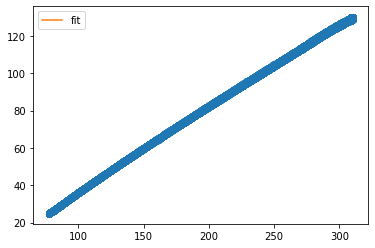

In [104]:
#Fitting straight line to the Cryostat temp - Therm Resistance graph

def linear(x,A,B): # defining the linear function
    y = B+A*x
    return y

parameters, covariance = curve_fit(linear, Temp_Cryostat_Cal, R_Therm_Cal, sigma = R_Therm_Cal_Err, absolute_sigma=True, p0=[0,1]) # Fitting the function

R0 = parameters[1] #Setting the variables 
Alpha = parameters[0]

Errors_linear = np.sqrt(np.diag(covariance))#Calculating the errors in the parameters
Alpha_Error = Errors_linear[0]
R0_Error = Errors_linear[1]

Linear_fit = R0+Alpha*(Temp_Cryostat_Cal)
print(parameters)
print(Alpha_Error, R0_Error)

plt.errorbar(Temp_Cryostat_Cal,R_Therm_Cal,yerr=R_Therm_Cal_Err, marker='o',linestyle="None")
plt.plot(Temp_Cryostat_Cal,Linear_fit,"-",label="fit")
plt.legend()


In [105]:
#Chi-Squared and P-Value for the linear function

Chi_Squared_Lin = np.sum(((R_Therm_Cal - Linear_fit)/R_Therm_Cal_Err)**2) #Calculating Reduced Chi-Squared

Dof = Temp_Cryostat_Cal.size - 2

Chi_Red = Chi_Squared_Lin/Dof

P_Value = scipy.stats.chi2.sf(Chi_Squared_Lin, Dof)

print(Chi_Red,P_Value)

17.060983831929658 0.0


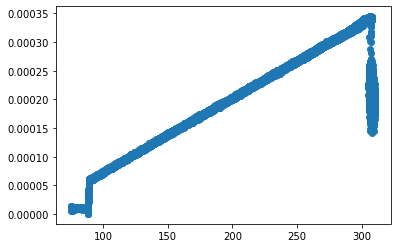

In [106]:
Calc_Temp = (R_Therm_Cal-R0)/Alpha # Calculating the temp from linear fit

Err_From_R0 = (R_Therm_Cal-(R0+R0_Error))/Alpha-Calc_Temp
Err_From_Alpha = (R_Therm_Cal-R0)/(Alpha+Alpha_Error)-Calc_Temp
Err_Temp_Total = np.sqrt(Err_From_R0**2+Err_From_Alpha**2 )

plt.plot(Calc_Temp,R_Sample_Cal,"o") # Plotting R0 to the temp

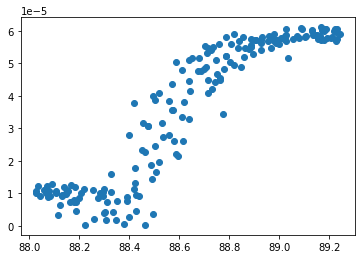

In [120]:
x_lower = Calc_Temp[Calc_Temp<89.25]
y_lower = R_Sample_Cal[np.nonzero(Calc_Temp<89.25)]
x_mid = x_lower[x_lower>88]
y_mid = y_lower[np.nonzero(x_lower>88)]

plt.scatter(x_mid,y_mid)


(-0.0005, 0.0005)

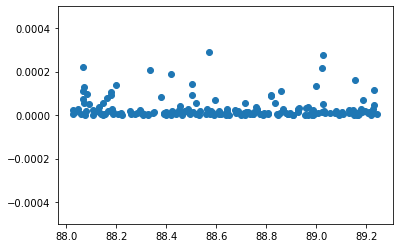

In [139]:
#Derivitive for the R_Sample


der = np.empty(x_mid.size-1)

for i in range(0,der.size):
    der[i]=abs((y_mid[i+1]-y_mid[i])/(x_mid[i+1]-x_mid[i]))
    
plt.scatter(x_mid[:der.size],der)

plt.ylim(-0.0005,0.0005)


In [42]:
#Fitting the derivitive of the R_Sample to the Gaussian

def Gauss(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

#popt_gauss, pcov_gauss = curve_fit(Gauss,Calc_Temp,Der_Sample,Der_Sample_Err,absolute_sigma=True, p0=[max(Der_Sample),0,1])
#Errors_Gauss = np.sqrt(np.diag(pcov_Gauss))


In [118]:
#For the Magnetic Field

B_Values = V_Hall/I_Hall
B_Max = max(B_Values)

Angles = np.degrees(np.arccos(B_Values/B_Max))


In [11]:
I_Therm_Cal

array([0.050583, 0.050552, 0.050615, ..., 0.0506  , 0.050502, 0.05051 ])